## sqlite

In [1]:
import sqlite3
dbfilename = "/opt/data/finefoods.db"
dbcon = sqlite3.connect(dbfilename)

In [2]:
cursor = dbcon.cursor()
sql = """
SELECT reviewhelpful, count(*)
FROM review
WHERE reviewscore < 2
GROUP BY reviewhelpful
"""
cursor.execute(sql)

In [3]:
from collections import Counter
ct = Counter()
for row_n, (score, count) in enumerate(cursor, 1):
    ct[score] = count
print(ct.most_common(n=5))

[('0/0', 12266), ('1/1', 4809), ('0/1', 3701), ('1/2', 2718), ('2/2', 2123)]


In [4]:
cursor = dbcon.cursor()
sql = """
SELECT reviewhelpful, count(*) AS ct
FROM review
WHERE reviewscore < 2
GROUP BY reviewhelpful
ORDER BY ct DESC
"""
cursor.execute(sql)
print(cursor.fetchmany(5))

[('0/0', 12266), ('1/1', 4809), ('0/1', 3701), ('1/2', 2718), ('2/2', 2123)]


## SQLalchemy

In [5]:
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine

Base = automap_base()

# engine, suppose it has two tables 'user' and 'address' set up
engine = create_engine("sqlite:////opt/data/finefoods.db")

In [6]:
Base.prepare(engine, reflect=True)
review = Base.classes.review

In [7]:
session = Session(engine)
from sqlalchemy import func # SQL functions

query = (session
         .query(review.reviewhelpful,
                func.count(review.reviewhelpful))
         .filter(review.reviewscore < 2)
         .group_by(review.reviewhelpful)
         .order_by(func.count(review.reviewhelpful).desc()))

res = query.all()
res[:5]

[('0/0', 12266), ('1/1', 4809), ('0/1', 3701), ('1/2', 2718), ('2/2', 2123)]

In [8]:
from sqlalchemy.dialects import sqlite
print(str(query.statement.compile(dialect=sqlite.dialect())))

SELECT review.reviewhelpful, count(review.reviewhelpful) AS count_1 
FROM review 
WHERE review.reviewscore < ? GROUP BY review.reviewhelpful ORDER BY count(review.reviewhelpful) DESC


# R's dplyr

In [9]:
from rpy2.robjects.lib import dplyr

datasrc  = dplyr.src_sqlite(dbfilename)
review_tbl = datasrc.get_table("review")

res =  (review_tbl
        .filter('reviewscore < 2')
        .count('reviewhelpful')
        .arrange('desc(n)'))

print(res)

Source: sqlite 3.8.6 [/opt/data/finefoods.db]
From: <derived table> [?? x 2]
Arrange: desc(n) 

   reviewhelpful     n
           (chr) (int)
1            0/0 12266
2            1/1  4809
3            0/1  3701
4            1/2  2718
5            2/2  2123
6            0/2  1702
7            2/3  1579
8            1/3  1342
9            3/3  1104
10           2/4   921
..           ...   ...



In [10]:
print(dplyr.dplyr.translate_sql(res))

<SQL> <S4 object of class "SQLiteConnection">
<SQL> /opt/data/finefoods.db
<SQL> 3.8.6
<SQL> FALSE
<SQL> (SELECT "reviewhelpful", COUNT() AS "n"
FROM "review"
WHERE "reviewscore" < 2.0
GROUP BY "reviewhelpful") AS "zzz1"
<SQL> reviewhelpful
<SQL> n
<SQL> FALSE
<SQL> FALSE
<SQL> desc(n)
<SQL> <environment>



## While with R...

In [11]:
from rpy2.robjects import r, globalenv
import rpy2.robjects.lib.ggplot2 as gg
p = (gg.ggplot((res.collect().
                mutate(r1 = 'as.integer(sapply(strsplit(reviewhelpful, "/"), "[", 1))',
                       r2 = 'as.integer(sapply(strsplit(reviewhelpful, "/"), "[", 2))'))) +
     gg.aes_string(x='r1+1', y='r2+1', size='n') +
     gg.geom_point(alpha = 0.5) +
     gg.scale_x_log10("review voted helpful") +
     gg.scale_y_log10("review") +
     gg.scale_size(trans="sqrt"))

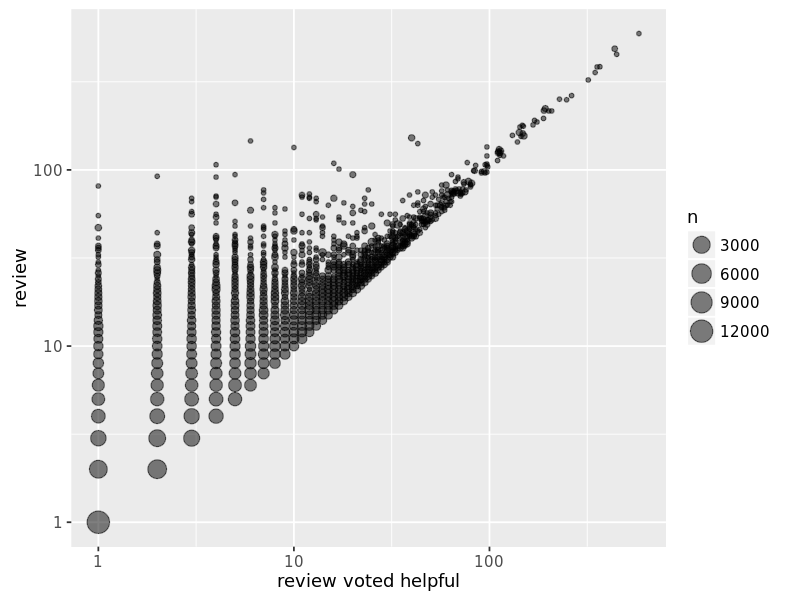

In [12]:
from rpy2.robjects.lib import grdevices

with grdevices.render_to_bytesio(grdevices.png, 
                                 width=800,
                                 height=600, 
                                 res=120) as b:
    p.plot()

from IPython.display import Image, display
data = b.getvalue()
display(Image(data=data, format='png', embed=True))

## Spark

In [13]:
import findspark
findspark.init()

import pyspark

conf = pyspark.conf.SparkConf()
(conf.setMaster('local[2]')
 .setAppName('ipython-notebook')
 .set("spark.executor.memory", "2g"))

sc = pyspark.SparkContext(conf=conf)

In [14]:
from pyspark.sql import SQLContext, Row
sqlcontext = SQLContext(sc)
cursor.execute('select * from review limit 10000')
review = sqlcontext.createDataFrame(cursor, tuple(x[0] for x in cursor.description))
review.registerTempTable("review")

In [15]:
sql = """
SELECT reviewhelpful, count(*) AS ct
FROM review
WHERE reviewscore < 2
GROUP BY reviewhelpful
ORDER BY ct DESC
"""
counts = sqlcontext.sql(sql)

In [16]:
res = counts.collect()

In [17]:
res[:5]

[Row(reviewhelpful='0/0', ct=241),
 Row(reviewhelpful='1/1', ct=87),
 Row(reviewhelpful='0/1', ct=80),
 Row(reviewhelpful='1/2', ct=72),
 Row(reviewhelpful='2/2', ct=39)]